In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.ndimage import gaussian_filter1d
from pyonset import Onset, BootstrapWindow
from anisotropy import run_SEPevent

In [39]:
data_path = f"{os.getcwd()}{os.sep}data"

onset_date = pd.to_datetime("2023-02-22")
start = onset_date - pd.Timedelta(days=1)
end = onset_date + pd.Timedelta(days=2)    # off by one, so three days are loaded now

event = run_SEPevent(data_path, spacecraft_instrument="Wind 3DP", starttime=start, endtime=end, species="e", channels=3, averaging="15min")

Input was Wind, using Wind.
Spacecraft: Wind
Instrument: 3DP. Species: e. Channels: 3.
11/15/2025 21:12:30 File is current: /home/osant/gradu/data/wind_masters/wi_h0_mfi_00000000_v01.cdf
11/15/2025 21:12:30 Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/
11/15/2025 21:12:30 File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230221_v05.cdf
11/15/2025 21:12:30 File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230222_v05.cdf
11/15/2025 21:12:30 File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230223_v05.cdf


(<Figure size 800x500 with 5 Axes>,
 array([<Axes: title={'center': 'Wind'}>,
        <Axes: ylabel='Pitch angle [$\\degree$]'>,
        <Axes: xlabel='Universal Time (UT)', ylabel='Intensity\n [1/(s$\\,$cm²$\\,$sr$\\,$MeV)]'>],
       dtype=object))

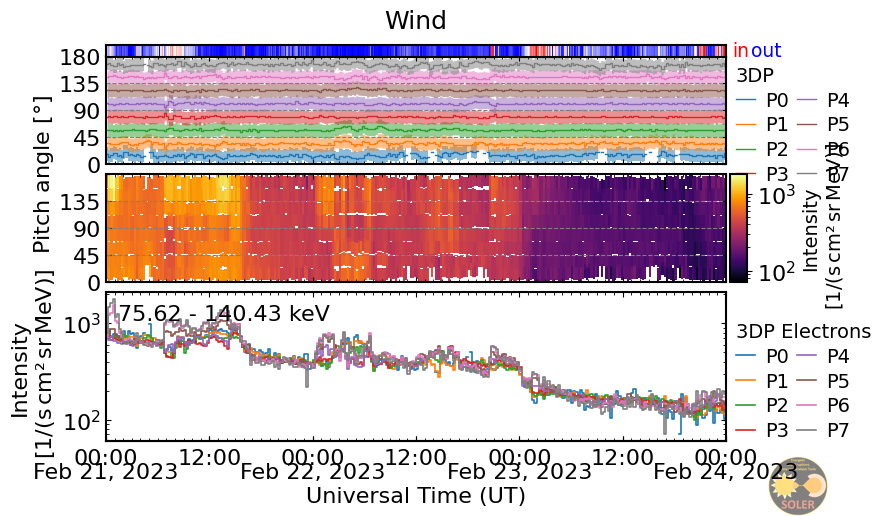

In [40]:
event.overview_plot()

1st idea: do Gaussian kernel smoothing on 15 minutes downsampled data. Find local optima of the time-series (look at where discrete difference changes signs). If consecutive optima with positive difference are an order of magnitude apart -> identify approximate onset there. Then do Poisson-CUSUM with 8 hrs initial background to get a better estimate of the onset. (Could consider hybrid method if computationally feasible but only an approximate one is needed, so this is easier)

2nd idea: from the obtained minima-maxima pairs, take the largest slope where the difference in intensity is still an order of magnitude.

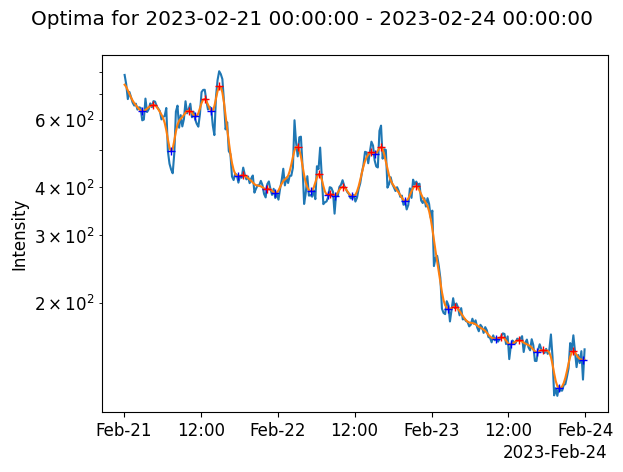

In [ ]:
from itertools import product

data = pd.Series(event.I_data[:,3], index=event.I_times)
data_smooth = gaussian_filter1d(data, sigma=2)
data_smooth_diff = np.diff(data_smooth)
arg_maxima = []
arg_minima = []
for i in range(len(data_smooth_diff)-1):
    if (data_smooth_diff[i + 1] > 0 and data_smooth_diff[i] < 0):
        arg_minima.append(i+1)
    elif (data_smooth_diff[i + 1] < 0 and data_smooth_diff[i] > 0):
        arg_maxima.append(i+1)

fig, ax = plt.subplots()
ax.plot(data)
ax.plot(data.index, data_smooth)
ax.plot(data.index[arg_minima], data_smooth[arg_minima], "b+")
ax.plot(data.index[arg_maxima], data_smooth[arg_maxima], "r+")
ax.set_yscale("log")
ax.set_ylabel("Intensity")
fig.suptitle(f"Optima for {start} - {end}")
fig.tight_layout()
plot_dir = f"{os.getcwd()}{os.sep}plots"
os.makedirs(plot_dir, exist_ok=True)
fname = plot_dir + os.sep + f"Wind_{start.strftime("%Y%m%d")}-{end.strftime("%Y%m%d")}"
fig.savefig(fname, bbox_inches="tight")

In [39]:
data_path = f"{os.getcwd()}{os.sep}data"
onset = Onset(start, end, "Wind", "3DP", "e", "l3", viewing="3", data_path=data_path)

100%|█████████████████████████████████████| 3.52M/3.52M [00:00<00:00, 4.82GB/s]


100%|████████████████████████████████████████| 606k/606k [00:00<00:00, 831MB/s]


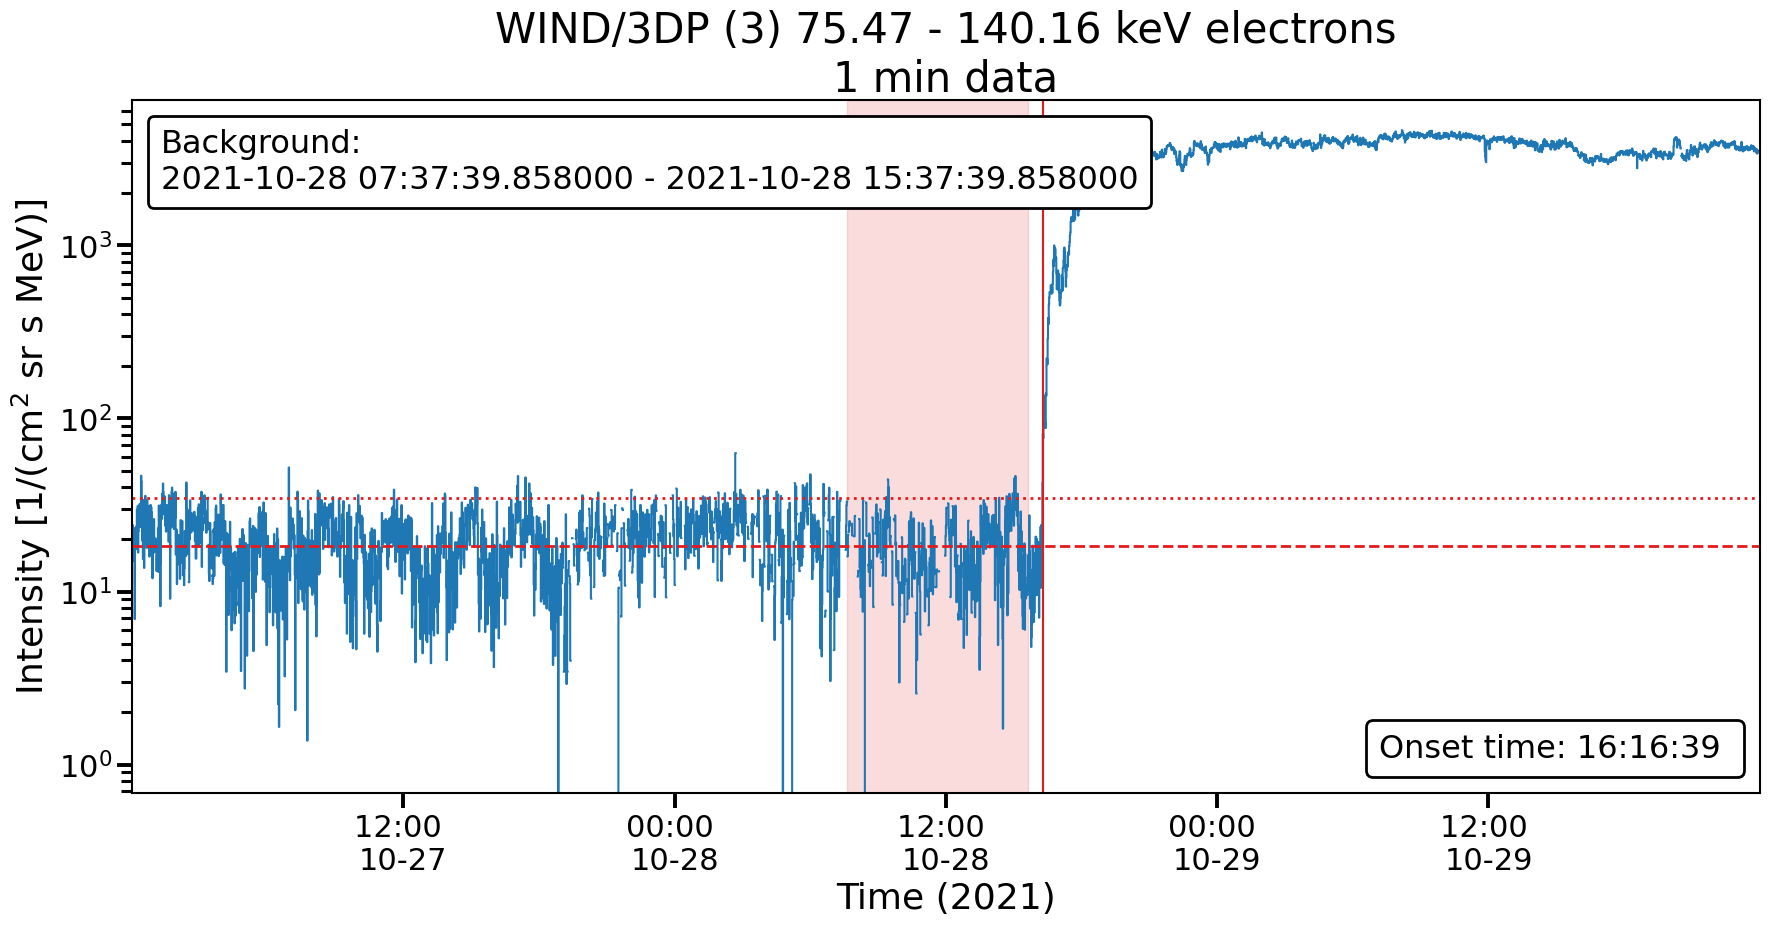

In [ ]:
csv_path = f"{os.getcwd()}{os.sep}wind_events.csv"
with open(csv_path, "+r", encoding="utf-8") as fp:
    event_no = len(fp.readlines())
    for i in range(len(arg_optima) - 1):
        if (data[arg_optima].iloc[i+1] / data[arg_optima].iloc[i] > 10) and (data[arg_optima].iloc[i + 1] > data[arg_optima].iloc[i]):
            bg_end = data[arg_optima].index[i]
            bg_start = bg_end - pd.Timedelta(hours=8)
            background = BootstrapWindow(bg_start, bg_end, bootstraps=1000)
            single_onset_stats, flux_series = onset.cusum_onset(channels=[3], background_range=background, 
                                                                        viewing="3", resample="1min", cusum_minutes=60,
                                                                        plot=True)
            onset_date = single_onset_stats[-1].date()
            onset_time = single_onset_stats[-1].time()
            fp.write(f"{event_no},{onset_date},{onset_time},{bg_start},{bg_end}")

In [ ]:
csv_path = f"{os.getcwd()}{os.sep}wind_events.csv"
with open(csv_path, "+r", encoding="utf-8") as fp:
    event_no = len(fp.readlines())
    

4


In [ ]:
def check_for_gaps(data, start, end, max_gap=1):
    flux_finite = data.dropna()
    for i in range(len(flux_finite[start:end]) - 1):
        if flux_finite.index[i + 1] - flux_finite.index[i] > pd.Timedelta(hours=max_gap):
            return True
        
    return False

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.ndimage import gaussian_filter1d
from pyonset import Onset, BootstrapWindow
from anisotropy import run_SEPevent

import sys
import logging
filehandler = logging.FileHandler(filename="wind_events.log", encoding="utf-8")
streamhandler = logging.StreamHandler(sys.stdout)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s', 
                    datefmt='%m/%d/%Y %H:%M:%S', handlers=[filehandler, streamhandler], force=True)


data_path = f"{os.getcwd()}{os.sep}data"
csv_path = f"{os.getcwd()}{os.sep}wind_events.csv"

for d in range(14):
    date = pd.to_datetime("2023-02-20") + pd.Timedelta(days=d)
    logging.info(f"Analyzing flux for {date}")
    start = date - pd.Timedelta(days=1)
    end = date + pd.Timedelta(days=2)    # off by one, so three days are loaded now
    try:
        event = run_SEPevent(data_path, spacecraft_instrument="Wind 3DP", starttime=start, endtime=end, 
                            species="e", channels=3, averaging="60min")         # maybe wget SFPD, SOPD from CDAWeb if SSL Berkeley is down
    except ValueError:
        continue

    # Data smoothing and finite difference optimization
    data = pd.Series(event.I_data[:,3], index=event.I_times)
    data_middle = data[date:(date + pd.Timedelta(days=1))]  # only consider the middle day for onset detection
    data_smooth = gaussian_filter1d(data_middle, sigma=1)   
    data_smooth_diff = np.diff(data_smooth)
    arg_optima = []
    for i in range(len(data_smooth_diff)-1):
        if (data_smooth_diff[i + 1] > 0 and data_smooth_diff[i] < 0) or (data_smooth_diff[i + 1] < 0 and data_smooth_diff[i] > 0):
            arg_optima.append(i+1)

    # Plot data, smoothed data and optima
    fig, ax = plt.subplots()
    ax.plot(data)
    ax.plot(data_middle.index, data_smooth)
    ax.plot(data_middle.index[arg_optima], data_smooth[arg_optima], "k+")
    ax.set_yscale("log")
    ax.set_ylabel("Intensity")
    fig.suptitle(f"Optima for {start} - {end}")
    fig.tight_layout()
    plot_dir = f"{os.getcwd()}{os.sep}plots"
    os.makedirs(plot_dir, exist_ok=True)
    fname = plot_dir + os.sep + f"Wind_{start.strftime("%Y%m%d")}-{end.strftime("%Y%m%d")}"
    fig.savefig(fname, bbox_inches="tight")
    plt.close(fig)

    # Rough onset determination with Poisson-CUSUM
    onset = Onset(start, end, "Wind", "3DP", "e", "l3", viewing="3", data_path=data_path)
    for i in range(len(arg_optima) - 1):
        n = 0
        opt1 = arg_optima[i]
        opt2 = arg_optima[i+1]
        if (data_middle.iloc[opt2] / data_middle.iloc[opt1] > 10) \
        and (data_middle.iloc[opt2] > data_middle.iloc[opt1]) \
        and check_for_gaps(data_middle, data_middle.index[opt1], data_middle.index[opt2]) is False:
            
            logging.info(f"Found a potential event between {data_middle[arg_optima].index[i]} - {data_middle[arg_optima].index[i+1]}")
            bg_end = data_middle[arg_optima].index[i]
            bg_start = bg_end - pd.Timedelta(hours=8)
            background = BootstrapWindow(bg_start, bg_end, bootstraps=1000)
            single_onset_stats, flux_series = onset.cusum_onset(channels=[3], background_range=background, 
                                                                        viewing="3", resample="1min", cusum_minutes=60,
                                                                        plot=False)
            try:
                onset_date = single_onset_stats[-1].date()
                onset_time = single_onset_stats[-1].time()
                logging.info(f"Poisson-CUSUM result: found onset {onset_date} {onset_time}\n" \
                             f"using background {bg_start} - {bg_end}")
                
                # Write to CSV
                with open(csv_path, "+r", encoding="utf-8") as fp:
                    event_no = len(fp.readlines())
                    fp.write(f"{event_no},{onset_date},{onset_time},{bg_start},{bg_end}\n")
                    logging.info(f"Results successfully saved to {csv_path}")
                    fp.close()
                
                n += 1

            except AttributeError:
                logging.info(f"Sufficient minimum ({opt1}) and maximum ({opt2}) were identified, but no onset was found")

    logging.info(f"Analysis for day {date} finished, {n} onsets found")

11/15/2025 21:15:56 Analyzing flux for 2023-02-20 00:00:00


Input was Wind, using Wind.
Spacecraft: Wind
Instrument: 3DP. Species: e. Channels: 3.
11/15/2025 21:16:03 File is current: /home/osant/gradu/data/wind_masters/wi_h0_mfi_00000000_v01.cdf
11/15/2025 21:16:03 Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_h0/2023/
11/15/2025 21:16:03 File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230219_v05.cdf
11/15/2025 21:16:04 File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230220_v05.cdf
11/15/2025 21:16:04 File is current: /home/osant/gradu/data/mfi/mfi_h0/2023/wi_h0_mfi_20230221_v05.cdf
11/15/2025 21:16:21 Analysis for day 2023-02-20 00:00:00 finished, 0 onsets found
11/15/2025 21:16:21 Analyzing flux for 2023-02-21 00:00:00
Input was Wind, using Wind.
Spacecraft: Wind
Instrument: 3DP. Species: e. Channels: 3.
11/15/2025 21:16:27 File is current: /home/osant/gradu/data/wind_masters/wi_h0_mfi_00000000_v01.cdf
11/15/2025 21:16:27 Downloading remote index: https://spdf.gsfc.nasa.gov

ConnectTimeout: HTTPSConnectionPool(host='sprg.ssl.berkeley.edu', port=443): Max retries exceeded with url: /wind3dp/data/wi/3dp/sfsp/2023//wi_sfsp_3dp_20230305_v01.cdf (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f7245d373b0>, 'Connection to sprg.ssl.berkeley.edu timed out. (connect timeout=30)'))

In [17]:
flux_finite = data.dropna()
for i in range(len(flux_finite[start:end]) - 1):
    if flux_finite.index[i + 1] - flux_finite.index[i] > pd.Timedelta(hours=1):
        print(flux_finite.index[i])
        print(flux_finite.index[i+1])
        print("Data gap found")

2023-02-24 21:32:11.112000
2023-02-25 07:32:11.112000
Data gap found
2023-02-25 09:32:11.112000
2023-02-26 03:32:11.112000
Data gap found


In [31]:
for i in range(len(arg_optima) - 1):
    opt1 = arg_optima[i]
    opt2 = arg_optima[i+1]
    if (data.iloc[opt2] / data.iloc[opt1] > 10) \
    and (data.iloc[opt2] > data.iloc[opt1]) \
    and check_for_gaps(data, data.index[opt1], data.index[opt2]) is False:
        print("Found onset")

In [23]:
data[arg_optima]

Epoch
2023-02-24 02:32:11.112      145.515549
2023-02-24 04:32:11.112      146.510300
2023-02-24 12:32:11.112      258.302734
2023-02-24 15:32:11.112      120.006096
2023-02-26 10:32:11.112    10497.947266
2023-02-26 14:32:11.112     7408.268066
2023-02-26 19:32:11.112    11732.869141
dtype: float32

In [26]:
for opt in arg_optima:
    print(data.index[opt])
    print(data.index[opt+1])

2023-02-24 02:32:11.112000
2023-02-24 03:32:11.112000
2023-02-24 04:32:11.112000
2023-02-24 05:32:11.112000
2023-02-24 12:32:11.112000
2023-02-24 13:32:11.112000
2023-02-24 15:32:11.112000
2023-02-24 16:32:11.112000
2023-02-26 10:32:11.112000
2023-02-26 11:32:11.112000
2023-02-26 14:32:11.112000
2023-02-26 15:32:11.112000
2023-02-26 19:32:11.112000
2023-02-26 20:32:11.112000


In [30]:
check_for_gaps(data, data.index[15], data.index[58])

True